In [2]:
import IPython.display as display
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import torchaudio
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from pathlib import Path
from PIL import Image
from torch.utils.data import Dataset
from torchvision import models, transforms

In [3]:
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=20, device="cpu"):
    for epoch in range(1, epochs+1):
        training_loss = 0.0
        valid_loss = 0.0
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)
            output = model(inputs)
            loss = loss_fn(output, targets)
            loss.backward()
            optimizer.step()
            training_loss += loss.data.item() * inputs.size(0)
        training_loss /= len(train_loader.dataset)
        
        model.eval()
        num_correct = 0 
        num_examples = 0
        for batch in val_loader:
            inputs, targets = batch
            inputs = inputs.to(device)
            output = model(inputs)
            targets = targets.to(device)
            loss = loss_fn(output,targets) 
            valid_loss += loss.data.item() * inputs.size(0)
            correct = torch.eq(torch.max(F.softmax(output), dim=1)[1], targets).view(-1)
            num_correct += torch.sum(correct).item()
            num_examples += correct.shape[0]
        valid_loss /= len(val_loader.dataset)

        print('Epoch: {}, Training Loss: {:.2f}, Validation Loss: {:.2f}, accuracy = {:.2f}'.format(epoch, training_loss,
        valid_loss, num_correct / num_examples))
        
def find_lr(model, loss_fn, optimizer, train_loader, init_value=1e-8, final_value=10.0, device="cpu"):
    number_in_epoch = len(train_loader) - 1
    update_step = (final_value / init_value) ** (1 / number_in_epoch)
    lr = init_value
    optimizer.param_groups[0]["lr"] = lr
    best_loss = 0.0
    batch_num = 0
    losses = []
    log_lrs = []
    for data in train_loader:
        batch_num += 1
        inputs, targets = data
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)

        # Crash out if loss explodes

        if batch_num > 1 and loss > 4 * best_loss:
            if(len(log_lrs) > 20):
                return log_lrs[10:-5], losses[10:-5]
            else:
                return log_lrs, losses

        # Record the best loss

        if loss < best_loss or batch_num == 1:
            best_loss = loss

        # Store the values
        losses.append(loss.item())
        log_lrs.append((lr))

        # Do the backward pass and optimize

        loss.backward()
        optimizer.step()

        # Update the lr for the next step and store

        lr *= update_step
        optimizer.param_groups[0]["lr"] = lr
    if(len(log_lrs) > 20):
        return log_lrs[10:-5], losses[10:-5]
    else:
        return log_lrs, losses

In [6]:

class ESC50(Dataset):
    def __init__(self,path):
        # Get directory listing from path
        files = Path(path).glob('*.wav')
        # Iterate through the listing and create a list of tuples (filename, label)
        self.items = [(str(f),f.name.split("-")[-1].replace(".wav","")) for f in files]
        self.length = len(self.items)
    def __getitem__(self, index):
        filename, label = self.items[index]
        audioTensor, rate = torchaudio.load(filename)
        return (audioTensor, int(label))     
    def __len__(self):
        return self.length

In [11]:
device="cuda"
bs=64
PATH_TO_ESC50 = Path.cwd() / 'esc50'

train_esc50 = ESC50(PATH_TO_ESC50 / "audio" /"train")
valid_esc50 = ESC50(PATH_TO_ESC50 / "audio" /"valid")


train_loader = torch.utils.data.DataLoader(train_esc50, batch_size = bs, shuffle = True)
valid_loader = torch.utils.data.DataLoader(valid_esc50, batch_size = bs, shuffle = True)


In [14]:
 class AudioNet(nn.Module):
    def __init__(self):
        super(AudioNet, self).__init__()
        self.conv1 = nn.Conv1d(100, 128, kernel_size=5, stride=4)
        self.bn1 = nn.BatchNorm1d(128)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(128, 128, 3)
        self.bn2 = nn.BatchNorm1d(128)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(128, 256, 3)
        self.bn3 = nn.BatchNorm1d(256)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(256, 512, 3)
        self.bn4 = nn.BatchNorm1d(512)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(512, 50)

    def forward(self, x):
        x = x.unsqueeze(-1).view(-1, 100, 2205)
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = x.squeeze(-1)
        x = self.fc1(x)
        return x

In [15]:
audionet = AudioNet()
audionet.to(device)

AudioNet(
  (conv1): Conv1d(100, 128, kernel_size=(5,), stride=(4,))
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(128, 256, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(256, 512, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=50, 

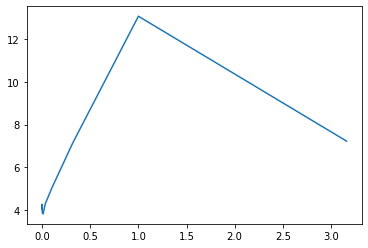

In [16]:
torch.save(audionet.state_dict(), "audionet.pth")
optimizer = optim.Adam(audionet.parameters(), lr=0.001)
logs,losses = find_lr(audionet, nn.CrossEntropyLoss(), optimizer, train_loader, device=device)

plt.plot(logs,losses)

In [17]:
lr = 1e-5
audionet.load_state_dict(torch.load("audionet.pth"))
optimizer = optim.Adam(audionet.parameters(), lr=lr)

In [19]:
train(audionet, optimizer, torch.nn.CrossEntropyLoss(),train_loader, valid_loader, epochs=100, device=device)

<ipython-input-3-c273bbe3bad0>:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  correct = torch.eq(torch.max(F.softmax(output), dim=1)[1], targets).view(-1)


Epoch: 1, Training Loss: 3.17, Validation Loss: 3.70, accuracy = 0.09
Epoch: 2, Training Loss: 3.14, Validation Loss: 3.69, accuracy = 0.09
Epoch: 3, Training Loss: 3.11, Validation Loss: 3.68, accuracy = 0.10
Epoch: 4, Training Loss: 3.08, Validation Loss: 3.67, accuracy = 0.10
Epoch: 5, Training Loss: 3.05, Validation Loss: 3.66, accuracy = 0.10
Epoch: 6, Training Loss: 3.03, Validation Loss: 3.66, accuracy = 0.10
Epoch: 7, Training Loss: 3.00, Validation Loss: 3.66, accuracy = 0.10
Epoch: 8, Training Loss: 2.97, Validation Loss: 3.65, accuracy = 0.10
Epoch: 9, Training Loss: 2.95, Validation Loss: 3.64, accuracy = 0.10
Epoch: 10, Training Loss: 2.92, Validation Loss: 3.64, accuracy = 0.10
Epoch: 11, Training Loss: 2.91, Validation Loss: 3.64, accuracy = 0.11
Epoch: 12, Training Loss: 2.87, Validation Loss: 3.62, accuracy = 0.10
Epoch: 13, Training Loss: 2.85, Validation Loss: 3.62, accuracy = 0.10
Epoch: 14, Training Loss: 2.83, Validation Loss: 3.61, accuracy = 0.10
Epoch: 15, Trai